In [87]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import load_model
import os
import numpy as np
import cv2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation,Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from skimage import io
from skimage.util import img_as_float
from skimage.transform import resize
import matplotlib.pyplot as plt
from keras.models import Model
from skimage import io, color, filters, measure

# FCN performance

In [88]:
train_data = np.load('train_data_112.npy')
test_data = np.load('test_data_112.npy')
train_images = train_data[:, :-12].reshape(-1, 112, 112, 3)
test_images = test_data[:, :-12].reshape(-1, 112, 112, 3)

In [89]:
train_X = train_images / 255.0
test_X = test_images / 255.0
input_shape = (112, 112, 3)
num_classes = 12

target_data = np.expand_dims(train_data[:, -12:], axis=(1, 2))
test_y = np.expand_dims(test_data[:, -12:], axis=(1, 2))
train_y = np.tile(target_data.reshape(-1, 1, 1, num_classes), (1, 112, 112, 1))
test_y = np.tile(test_y.reshape(-1, 1, 1, num_classes), (1, 112, 112, 1))
print(np.shape(test_X))
print(np.shape(train_y))
print(np.shape(test_y))

(3103, 112, 112, 3)
(12412, 112, 112, 12)
(3103, 112, 112, 12)


In [90]:
model_F= load_model('h5 files/fcn_model.h5')
test_loss, test_acc= model_F.evaluate(test_X, test_y)
print('Test accuracy:', test_acc)

97/97 [==============================] - 19s 199ms/step - loss: 0.8222 - accuracy: 0.7518
Test accuracy: 0.7518210411071777


# Xception+FCN performance

In [91]:
from tensorflow.keras import backend as K

def custom_precision(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def custom_recall(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def custom_f1_score(y_true, y_pred):
    precision = custom_precision(y_true, y_pred)
    recall = custom_recall(y_true, y_pred)
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

In [92]:
model_X = load_model('h5 files/xception_model.h5')

In [93]:
test_loss, test_acc= model_X.evaluate(test_X, test_y)
print('Test accuracy:', test_acc)

97/97 [==============================] - 12s 113ms/step - loss: 0.7394 - accuracy: 0.8484
Test accuracy: 0.8484143018722534


In [94]:
model_C = load_model('h5 files/cnn_model.h5')
test_images = test_data[:, :-12].reshape(-1, 112, 112, 3)
test_images = test_images / 255.0

In [95]:
test_loss, test_acc = model_C.evaluate(test_images, test_data[:, -12:])
print('Test accuracy:', test_acc)

97/97 [==============================] - 1s 8ms/step - loss: 1.3938 - accuracy: 0.7618
Test accuracy: 0.7618433833122253


# saliency map visualization

In [96]:
def saliency_map(image_path, flag):
    if flag == 1:
        model = model_F
    if flag == 2:
        model = model_X
    if flag == 3:
        model = model_C
    image = io.imread(image_path)
    image = img_as_float(image)
    image = resize(image, (112, 112))
    x = np.expand_dims(image, axis=0)

    x_tensor = tf.convert_to_tensor(x)
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        output = model(x_tensor)
    grads = tape.gradient(output, x_tensor)
    saliency_map = np.max(np.abs(grads), axis=-1)[0]
    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))

    return saliency_map
def plot_saliency_maps(image_path):

    image = io.imread(image_path)
    image = img_as_float(image)
    image = resize(image, (112, 112))


    s_map_F = saliency_map(image_path, 1)
    s_map_X = saliency_map(image_path, 2)
    s_map_C = saliency_map(image_path, 3)


    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    axs[1].imshow(s_map_F, cmap='hot')
    axs[1].set_title('Model F')
    axs[2].imshow(s_map_X, cmap='hot')
    axs[2].set_title('Model X')
    axs[3].imshow(s_map_C, cmap='hot')
    axs[3].set_title('Model C')


    fig.suptitle('Saliency Maps')
    plt.show()

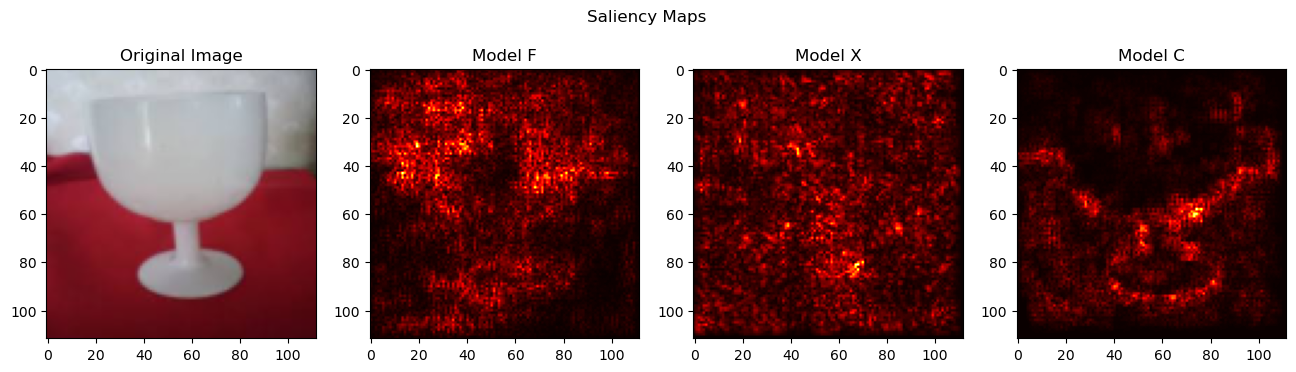

In [97]:
image_path = 'C:/Users/18589/Desktop/ECE176 project/white-glass/white-glass515.jpg'
plot_saliency_maps(image_path)

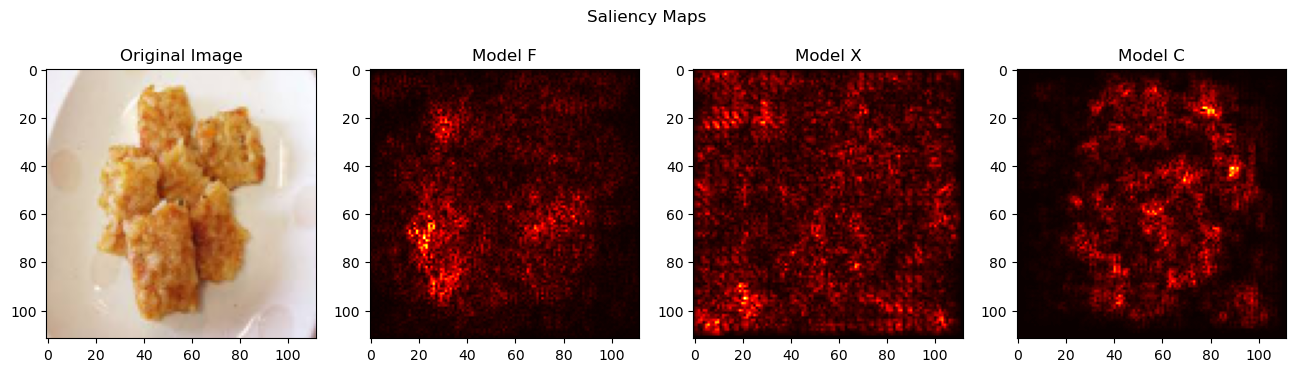

In [98]:
image_path = 'C:/Users/18589/Desktop/ECE176 project/biological/biological83.jpg'
plot_saliency_maps(image_path)

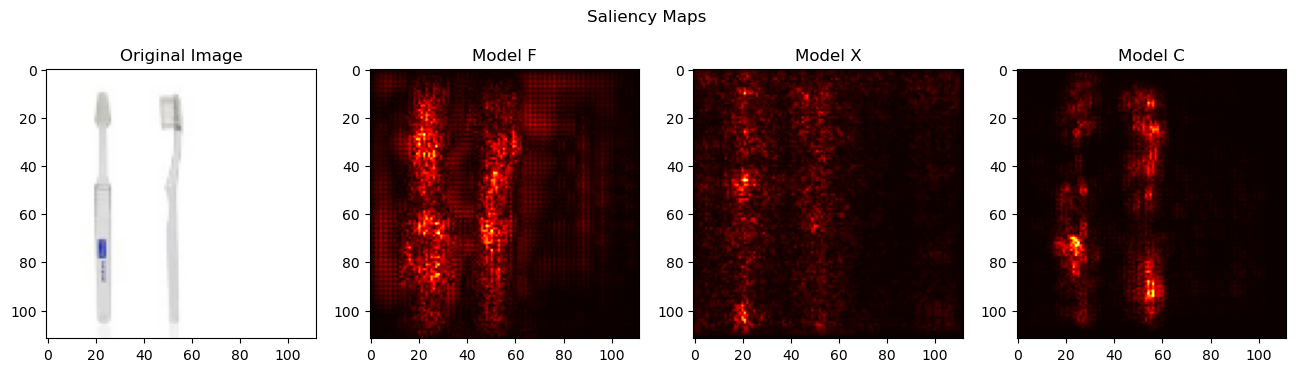

In [99]:
image_path = 'C:/Users/18589/Desktop/ECE176 project/trash/trash515.jpg'
plot_saliency_maps(image_path)

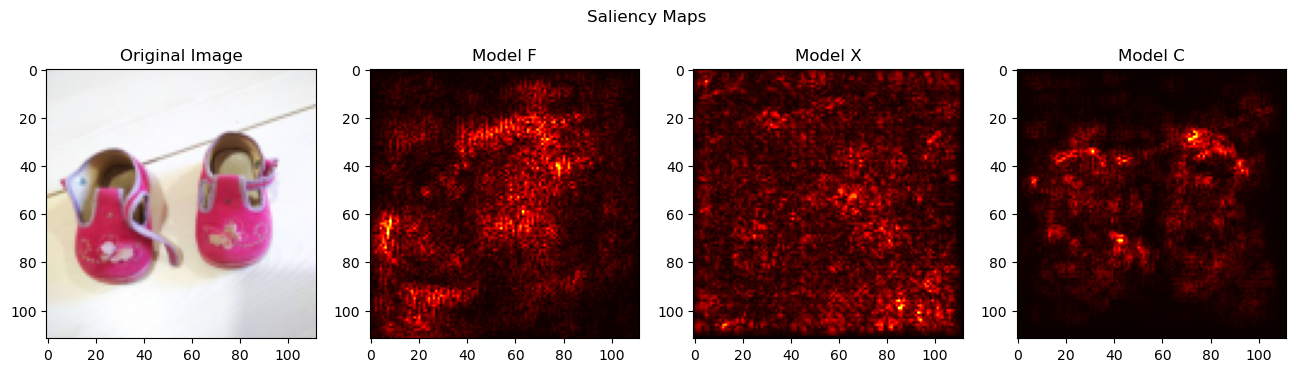

In [100]:
image_path = 'C:/Users/18589/Desktop/ECE176 project/shoes/shoes4.jpg'
plot_saliency_maps(image_path)

In [101]:

def contour_heat(image_path,flag,layer_name):
    if flag == 1:
        model = model_F
    if flag == 2:
        model = model_X
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    image = io.imread(image_path)
    image = img_as_float(image)
    image = resize(image, (112, 112))
    image = np.expand_dims(image, axis=0)
    intermediate_output = intermediate_layer_model.predict(image)
    mean_output = np.mean(intermediate_output, axis=0)
    if mean_output.shape[-1] > 3:
        mean_output = mean_output[..., :3]

    gray = color.rgb2gray(mean_output)
    thresh = filters.threshold_otsu(gray)
    binary = gray > thresh

    contours = measure.find_contours(binary, 0.5)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(image[0])
    ax2.contourf(mean_output[:,:,0], cmap='Reds', alpha=0.5)
    ax2.contourf(mean_output[:,:,1], cmap='Greens', alpha=0.5)
    ax2.contourf(mean_output[:,:,2], cmap='Blues', alpha=0.5)
        
    for cnt in contours:
        ax2.plot(cnt[:, 1], cnt[:, 0], linewidth=2, color='black')
    heatmap = np.zeros(binary.shape + (3,))
    heatmap[binary] = (1, 0, 0)
    ax3.imshow(heatmap)

    plt.show()
    

1/1 [==============================] - 0s 63ms/step


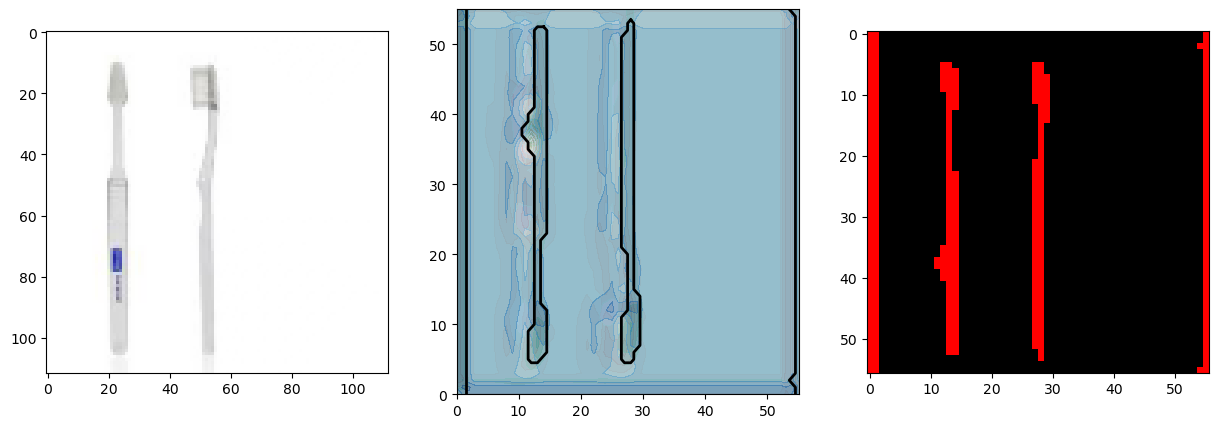

1/1 [==============================] - 1s 503ms/step


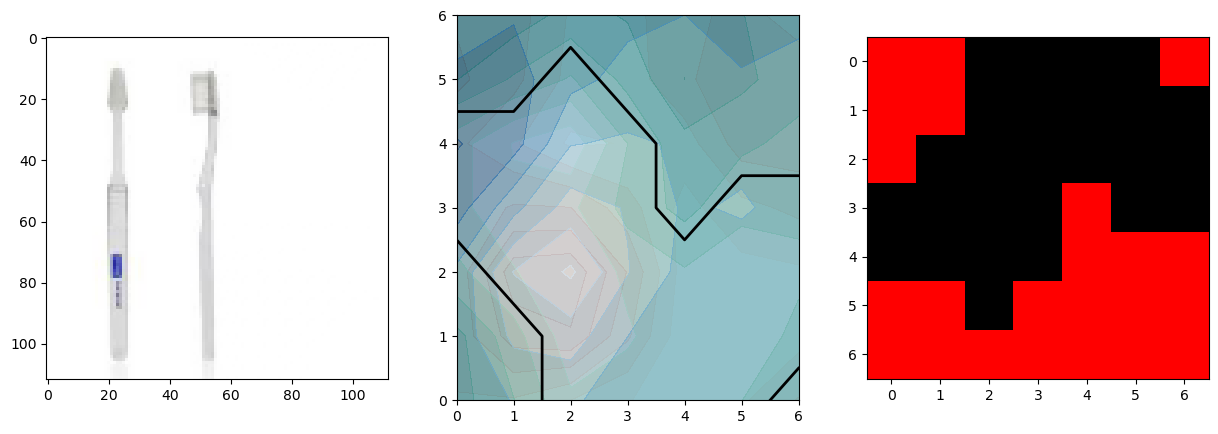

In [102]:
image_path = 'C:/Users/18589/Desktop/ECE176 project/trash/trash515.jpg'
layer_name = 'conv2d_3'
contour_heat(image_path,1,layer_name)
layer_name = 'block13_sepconv2'
contour_heat(image_path,2,layer_name)

1/1 [==============================] - 0s 50ms/step


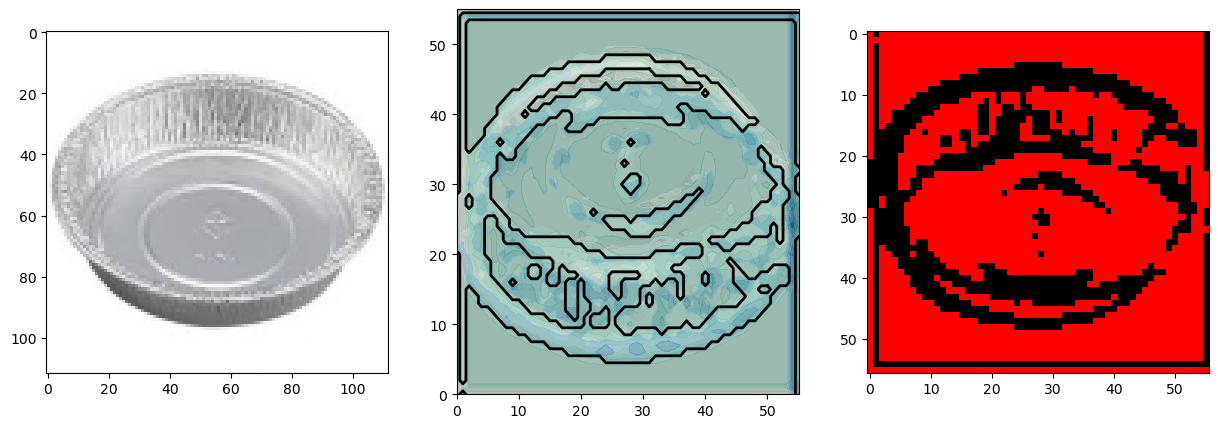

1/1 [==============================] - 0s 60ms/step


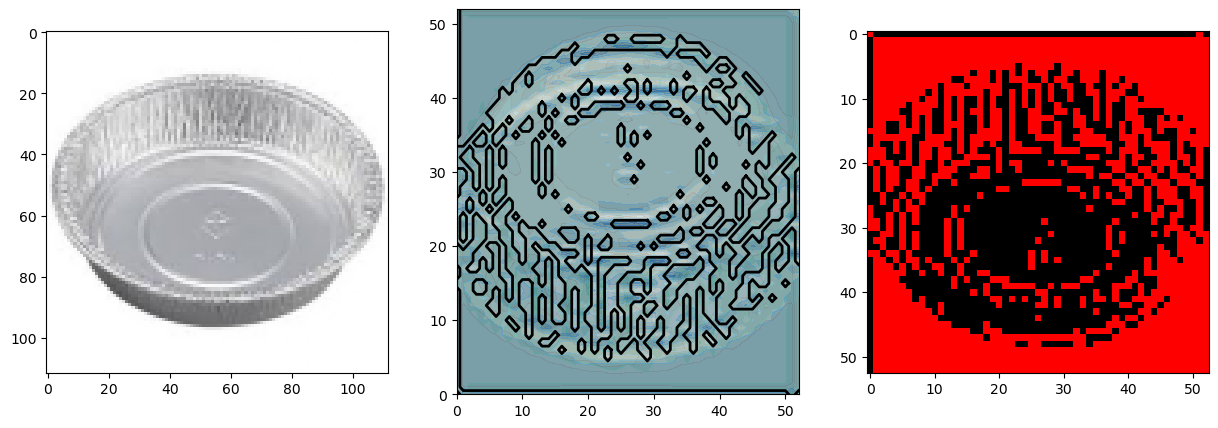

In [86]:
image_path = 'C:/Users/18589/Desktop/ECE176 project/metal/metal6.jpg'
layer_name = 'conv2d_2'
contour_heat(image_path,1,layer_name)
layer_name = 'block2_sepconv2'
contour_heat(image_path,2,layer_name)